In [1]:
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import dataloader
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import shap

In [2]:
# pretrained_model=net(previously used in training)
def pretrained_model(num_output_class, device, fine_tune):
    '''
    TODO: Complete this function that initializes your model
          Remember to use a pretrained model
    '''
    model_conv = models.resnet18(pretrained=True)
    model_conv.eval()
    if not fine_tune:
        for param in model_conv.parameters():
            param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_output_class)
    return model_conv.to(device)

In [3]:
def create_data_loaders(data_type, batch_size, data_dir):
    '''
    This is an optional function that you may or may not need to implement
    depending on whether you need to use data loaders or not
    '''
    
    '''
    Data preprocessing
    '''
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    assert data_type in ['train', 'valid', 'test']
    if data_type == 'train' or data_type == 'valid':
        type_list = ['train', 'valid']
    else:
        type_list = ['test']
    dataloaders = {x: torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]),
                                                    batch_size=batch_size, shuffle=True, num_workers=4) for x in type_list}
    return dataloaders

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [5]:
# Load previously trained model
data_dir = os.path.normpath(r'./data/Image/')
model_path = './Model/SGD_scheduler_fine_tune.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = datasets.ImageFolder(os.path.join(data_dir, 'test')).classes
num_output_class = len(class_names)
checkpoint = torch.load(model_path, map_location=device)
fine_tune = True
model = pretrained_model(num_output_class, device, fine_tune)
model.load_state_dict(checkpoint)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


<All keys matched successfully>

In [6]:
data_dir = os.path.normpath(r'./data/Image/')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = datasets.ImageFolder(os.path.join(data_dir, 'test')).classes

In [7]:
test_loader = create_data_loaders('test', 32, data_dir)

In [8]:
iter_batch = iter(test_loader['test'])
inputs, classes = next(iter_batch)

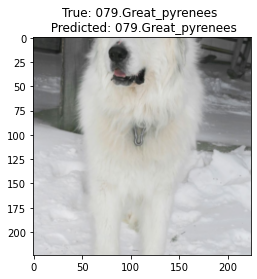

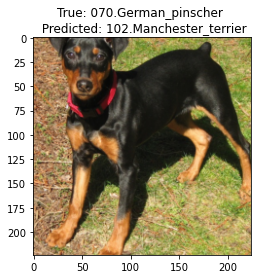

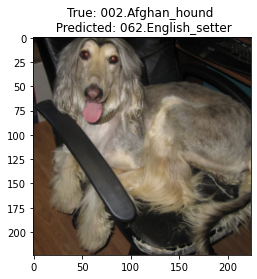

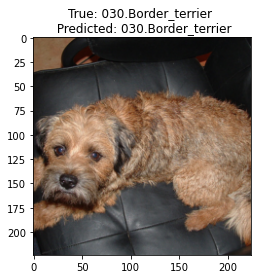

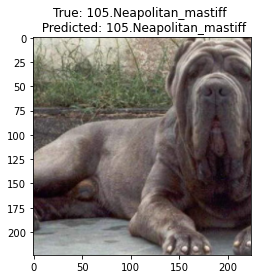

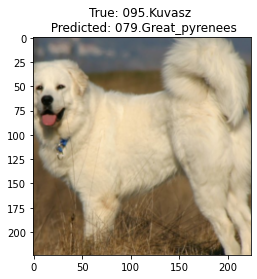

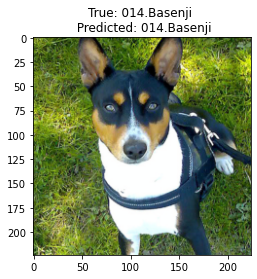

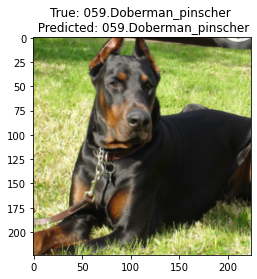

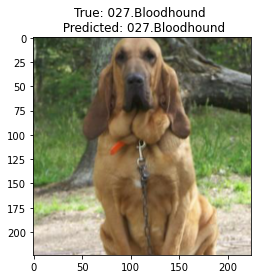

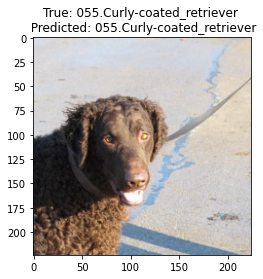

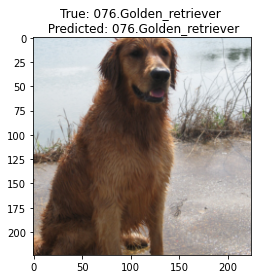

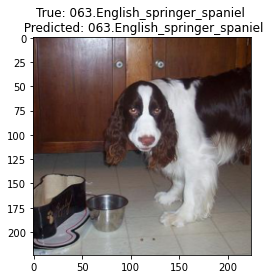

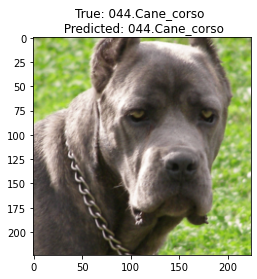

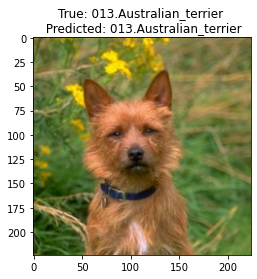

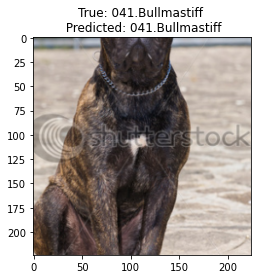

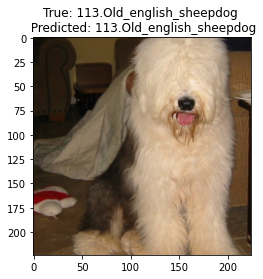

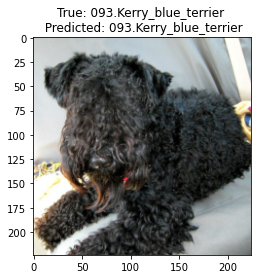

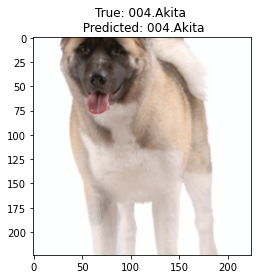

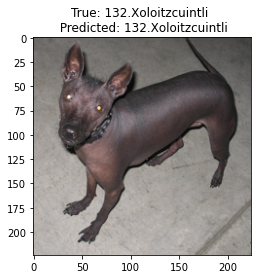

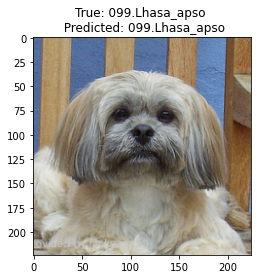

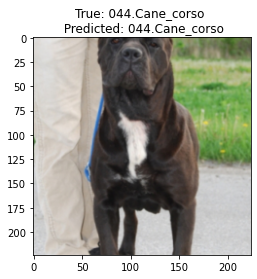

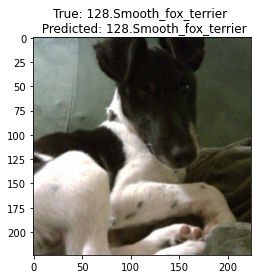

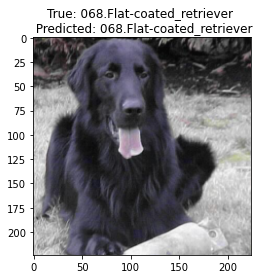

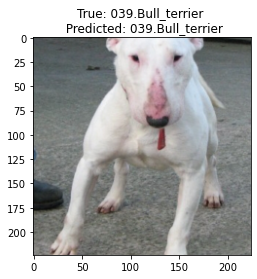

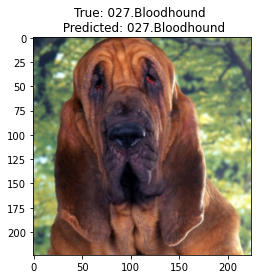

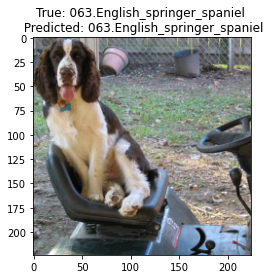

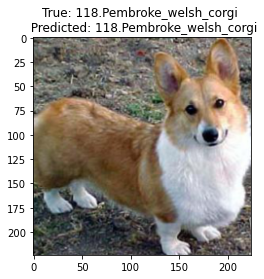

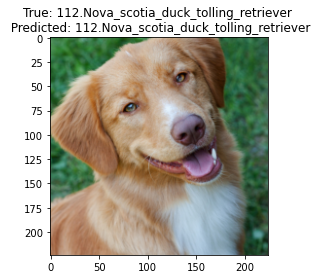

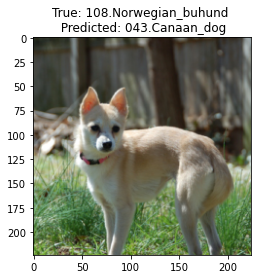

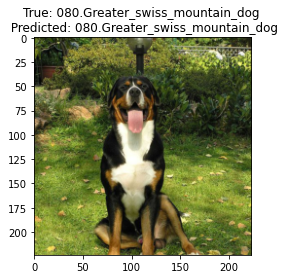

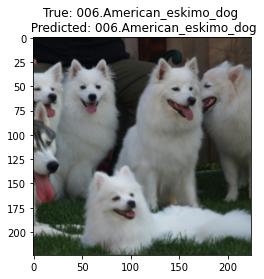

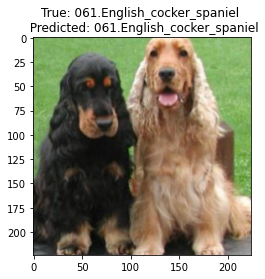

In [9]:
# Evaluate
inputs = inputs.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)
images_so_far = 0
for j in range(inputs.size()[0]):
    title = f'True: {class_names[classes[j]]} \n Predicted: {class_names[preds[j]]}'
    imshow(inputs.cpu().data[j], title);

In [10]:
X = inputs.permute((0,2,3,1)).numpy()

In [11]:
tensor_trans = transforms.Compose([
    transforms.ToTensor()
]) 
# python function to get model output; replace this function with your own model function.
def f(x):
    batch = torch.stack(tuple(tensor_trans(i) for i in x), dim=0)
    return model(batch)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[0:2], max_evals=10, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


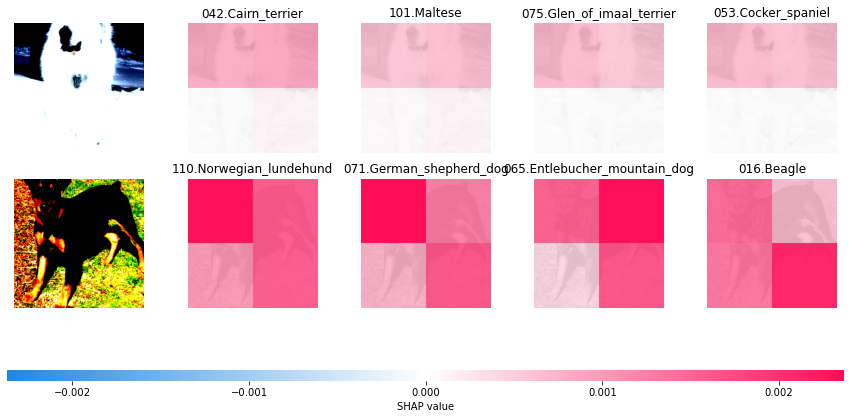

In [12]:
shap.image_plot(shap_values)

# Final example

In [13]:
def dog_breed_img(breed_id_list):
    def get_image(path):
        with open(os.path.abspath(path), 'rb') as f:
            with Image.open(f) as img:
                return img.convert('RGB')
    pil_trans = nn.Sequential(
    transforms.Resize(256),
    transforms.CenterCrop(224)
    )
    img_list = []
    for breed_id in breed_id_list:
        path = './data/Image/test/' + breed_id
        files = os.listdir(path)
        file_name = np.random.choice(files, 1)[0]
        img = get_image(path + '/' + file_name)
        img_np = np.array(pil_trans(img))
        img_list.append(img_np)
    return np.array(img_list)

In [14]:
breed_id_list = ['044.Cane_corso', '034.Boxer']

In [33]:
X = dog_breed_img(breed_id_list)

In [16]:
tensor_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 

In [36]:
# python function to get model output; replace this function with your own model function.
def f(x):
    batch = torch.stack(tuple(tensor_trans(i) for i in x), dim=0)
    return model(batch)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[0:2], max_evals=500, batch_size=32, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|███████████████████████████████████▌                                   | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [00:38, 19.29s/it]                                                                            


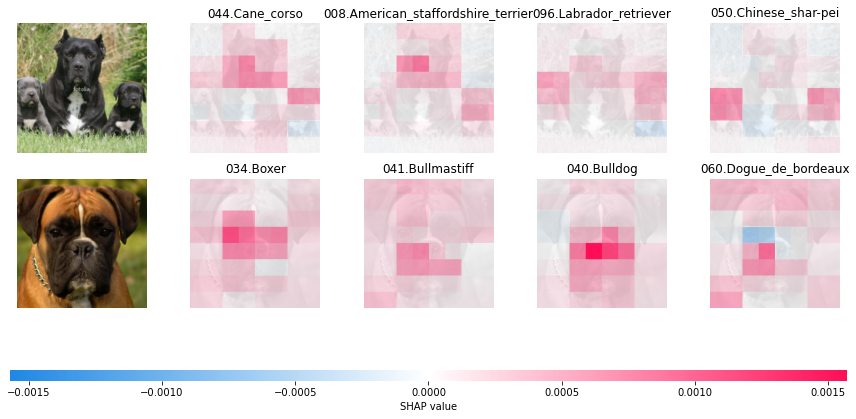

In [37]:
shap.image_plot(shap_values)

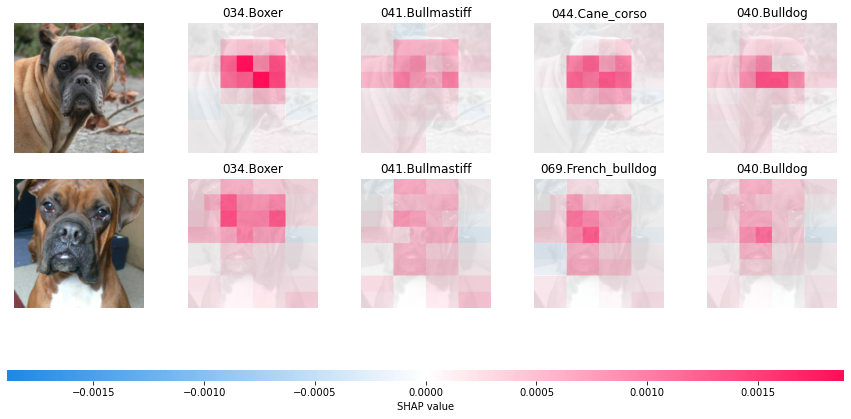

In [26]:
shap.image_plot(shap_values)